In [ ]:
# @title 1. Setup and Library Import
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
from tqdm.notebook import tqdm

# Set random seed for reproducibility
np.random.seed(42)

Mounted at /content/drive


In [ ]:
# @title 2. Data Loading & Configuration
# ==========================================

JANSSEN_PATH = '/content/drive/MyDrive/Thesis data/Processed_Dataset.csv'
NORMAL_PATH = '/content/drive/MyDrive/Thesis data/LBNL_FDD_Dataset_SDAHU/AHU_annual.csv'
FAULTY_FOLDER_PATH = '/content/drive/MyDrive/Thesis data/LBNL_FDD_Dataset_SDAHU/Faulty_Files/'
JANSSEN_FAULT_COL = 'Fault'
JANSSEN_TIMESTAMP_COL = 'Timestamp'

# MAPPING DICTIONARY: Map Filenames to Intensity (1, 2)
FAULT_INTENSITY_MAP = {
    'coi_bias_2_annual.csv': 1,
    'coi_bias_-2_annual.csv': 1,
    'coi_bias_4_annual.csv': 2,
    'coi_bias_-4_annual.csv': 2,
    'coi_leakage_010_annual.csv': 2,
    'coi_leakage_025_annual.csv': 1,
    'coi_leakage_040_annual.csv': 1,
    'coi_leakage_050_annual.csv': 2,
    'coi_stuck_010_annual.csv': 2,
    'coi_stuck_025_annual.csv': 1,
    'coi_stuck_050_annual.csv': 1,
    'coi_stuck_075_annual.csv': 2,
    'damper_stuck_010_annual.csv': 2,
    'damper_stuck_025_annual.csv': 1,
    'damper_stuck_075_annual.csv': 1,
    'damper_stuck_100_annual_short.csv': 2,
    'oa_bias_2_annual.csv': 1,
    'oa_bias_-2_annual.csv': 1,
    'oa_bias_4_annual.csv': 2,
    'oa_bias_-4_annual.csv': 2
}

# Correlation threshold for removing features (0.95 = 95% correlation)
CORR_THRESHOLD = 0.95

# ==========================================

def load_data():
    print("Loading Janssen Dataset...")
    df_janssen = pd.read_csv(JANSSEN_PATH)

    print("Loading Normal State Dataset...")
    df_normal = pd.read_csv(NORMAL_PATH)

    print(f"Loading Faulty State Datasets from {FAULTY_FOLDER_PATH}...")
    faulty_files = glob.glob(os.path.join(FAULTY_FOLDER_PATH, "*.csv"))

    if len(faulty_files) == 0:
        raise ValueError("No CSV files found in the faulty folder!")

    faulty_dfs = {}
    for f in faulty_files:
        name = os.path.basename(f)
        try:
            temp_df = pd.read_csv(f)
            faulty_dfs[name] = temp_df
        except Exception as e:
            print(f"Error loading {name}: {e}")

    print(f"Successfully loaded {len(faulty_dfs)} faulty variations.")
    return df_janssen, df_normal, faulty_dfs

df_janssen, df_normal, faulty_dict = load_data()

Loading Janssen Dataset...
Loading Normal State Dataset...
Loading Faulty State Datasets from /content/drive/MyDrive/Thesis data/LBNL_FDD_Dataset_SDAHU/Faulty_Files/...
Successfully loaded 20 faulty variations.


Analyzing Janssen Dataset Patterns...
Detected Sampling Frequency: Every 15.0 minutes


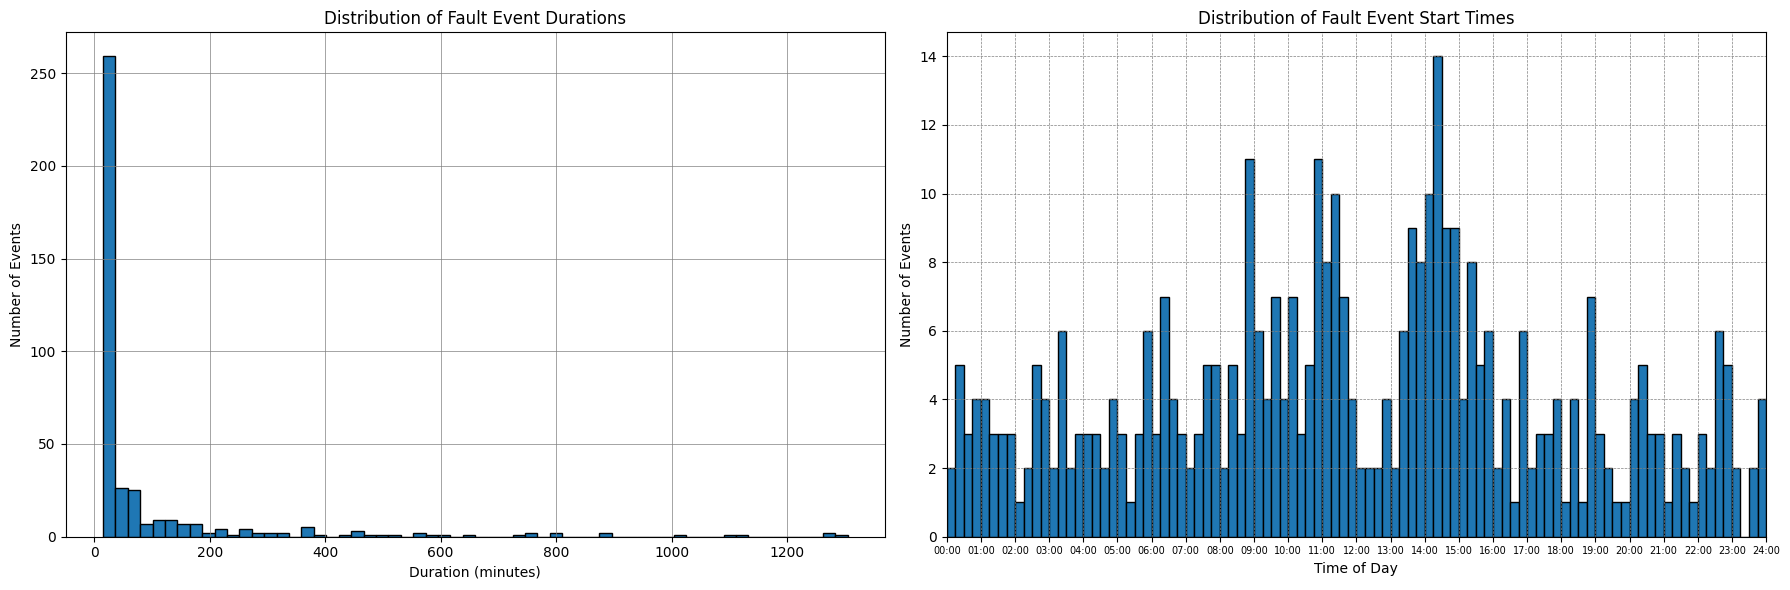

--- Stats ---
Total Fault Percentage: 1.99%
Total Events: 397


In [ ]:
# @title 3. Extract Empirical Distributions (with Exact Plot Style)
def analyze_fault_patterns(df, fault_col, time_col):
    """
    Analyzes binary fault column to extract start times, durations (in mins), and gaps.
    Plots them exactly like the requested image.
    """
    # Ensure the timestamp column is in datetime format
    df[time_col] = pd.to_datetime(df[time_col])

    # 1. Detect Sampling Frequency (in Minutes)
    # We assume the data is sorted and evenly spaced
    time_diff = df[time_col].iloc[1] - df[time_col].iloc[0]
    freq_minutes = time_diff.total_seconds() / 60
    print(f"Detected Sampling Frequency: Every {freq_minutes} minutes")

    # 2. Identify Fault Start/Ends
    df[fault_col] = df[fault_col].astype(int)
    df['change'] = df[fault_col].diff()

    starts = df.index[df['change'] == 1].tolist()
    ends = df.index[df['change'] == -1].tolist()

    # Handle edge cases
    if df[fault_col].iloc[0] == 1: starts.insert(0, 0)
    if df[fault_col].iloc[-1] == 1: ends.append(len(df))

    if len(starts) != len(ends):
        min_len = min(len(starts), len(ends))
        starts = starts[:min_len]
        ends = ends[:min_len]

    # 3. Calculate Durations (Rows & Minutes)
    durations_rows = np.array(ends) - np.array(starts)
    durations_mins = durations_rows * freq_minutes

    # 4. Calculate Gaps (Rows)
    gaps = []
    if len(starts) > 1:
        gaps = np.array(starts[1:]) - np.array(ends[:-1])

    # 5. Extract Start Time of Day (Minutes from Midnight)
    start_timestamps = df[time_col].iloc[starts]
    # Convert timestamp to "minutes since midnight"
    start_mins_from_midnight = start_timestamps.dt.hour * 60 + start_timestamps.dt.minute

    # ==========================================
    # PLOTTING (MATCHING THE REQUESTED IMAGE)
    # ==========================================
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # --- Plot 1: Distribution of Fault Event Durations ---
    # Using plt.hist with black edges to match the style
    axes[0].hist(durations_mins, bins=60, color='#1f77b4', edgecolor='black')
    axes[0].set_title('Distribution of Fault Event Durations')
    axes[0].set_xlabel('Duration (minutes)')
    axes[0].set_ylabel('Number of Events')
    axes[0].grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')

    # --- Plot 2: Distribution of Fault Event Start Times ---
    # Bins for every 15 minutes of the day (0, 15, 30, ..., 1440)
    bins_15min = np.arange(0, 24*60 + 15, 15)

    axes[1].hist(start_mins_from_midnight, bins=bins_15min, color='#1f77b4', edgecolor='black')
    axes[1].set_title('Distribution of Fault Event Start Times')
    axes[1].set_xlabel('Time of Day')
    axes[1].set_ylabel('Number of Events')
    axes[1].set_xlim(0, 1440)
    axes[1].grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')

    # Set x-ticks for every hour and label them
    hour_ticks = np.arange(0, 24*60 + 60, 60) # 0, 60, 120...
    hour_labels = [f"{h:02d}:00" for h in range(25)]
    axes[1].set_xticks(hour_ticks)
    # Use a smaller font size to fit all 24 labels nicely
    axes[1].set_xticklabels(hour_labels, fontsize=7)

    plt.tight_layout()
    plt.show()

    return {
        'percentage': (df[fault_col].sum() / len(df)) * 100,
        'durations': durations_rows, # We still use rows for the injection logic
        'gaps': gaps,
        'count': len(starts)
    }

print("Analyzing Janssen Dataset Patterns...")
janssen_stats = analyze_fault_patterns(df_janssen, JANSSEN_FAULT_COL, JANSSEN_TIMESTAMP_COL)

print(f"--- Stats ---")
print(f"Total Fault Percentage: {janssen_stats['percentage']:.2f}%")
print(f"Total Events: {janssen_stats['count']}")

In [ ]:
# @title 4. Inject Faults into Normal Data (With Intensity)
def inject_faults(normal_df, faulty_dict, stats_dict, intensity_map):
    synthetic_df = normal_df.copy()

    # Initialize Target Columns
    synthetic_df['Fault'] = 0
    synthetic_df['Intensity'] = 0  # Default to 0 (Normal)

    pool_durations = stats_dict['durations']
    pool_gaps = stats_dict['gaps']
    faulty_keys = list(faulty_dict.keys())

    current_index = 0
    max_index = len(synthetic_df)
    total_injected_events = 0

    # Initial offset
    if len(pool_gaps) > 0:
        current_index += np.random.choice(pool_gaps)

    print("Starting Injection Process...")

    while current_index < max_index:
        duration = np.random.choice(pool_durations)

        if current_index + duration >= max_index:
            break

        # Select a Random Faulty File
        selected_key = random.choice(faulty_keys)

        # Check if selected key exists in map (error handling)
        if selected_key not in intensity_map:
            print(f"Warning: {selected_key} not found in intensity map. Skipping.")
            continue

        faulty_source = faulty_dict[selected_key]
        intensity_val = intensity_map[selected_key]

        # Columns to overwrite (exclude 'Fault', 'Intensity', and 'Datetime' if they exist in source)
        # We only want to overwrite the actual feature columns with faulty data.
        cols_to_overwrite = [c for c in normal_df.columns if c not in ['Datetime']]

        # Extract slice
        faulty_slice = faulty_source.iloc[current_index : current_index + duration][cols_to_overwrite]

        # Overwrite features using .loc for robust assignment
        # This handles potential type mismatches better than direct .values assignment with .iloc
        synthetic_df.loc[synthetic_df.index[current_index : current_index + duration], cols_to_overwrite] = faulty_slice

        # Set Fault Label
        synthetic_df.iloc[current_index : current_index + duration, synthetic_df.columns.get_indexer(['Fault'])] = 1

        # Set Intensity Label
        synthetic_df.iloc[current_index : current_index + duration, synthetic_df.columns.get_indexer(['Intensity'])] = intensity_val

        total_injected_events += 1
        current_index += duration

        if len(pool_gaps) > 0:
            gap = np.random.choice(pool_gaps)
            current_index += gap
        else:
            current_index += duration

    print(f"Injection Complete. Total Events: {total_injected_events}")
    return synthetic_df

# Run injection
df_final = inject_faults(df_normal, faulty_dict, janssen_stats, FAULT_INTENSITY_MAP)

Starting Injection Process...
Injection Complete. Total Events: 1802


Final Fault Percentage: 2.12%

Intensity Distribution (Row Counts):
Intensity
0    514377
2      5592
1      5571
Name: count, dtype: int64


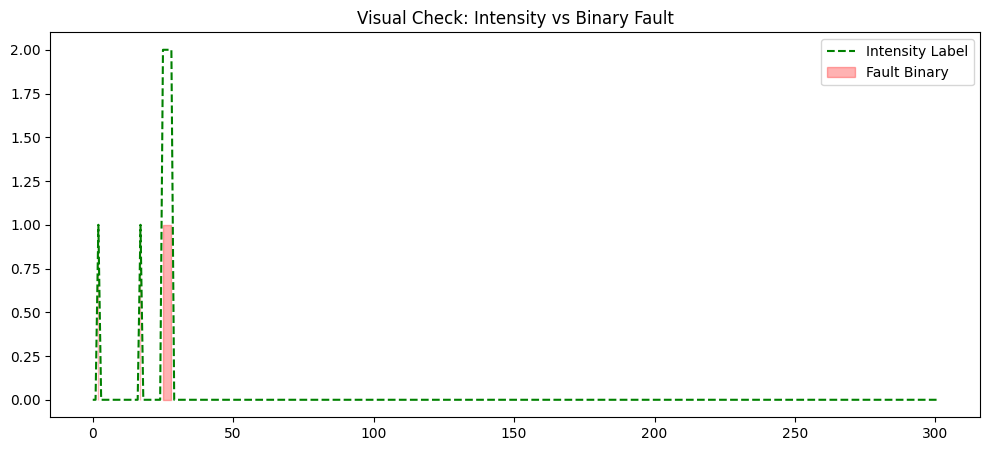

In [ ]:
# @title 5. Verification
def verify_dataset(df):
    fault_count = df['Fault'].sum()
    total = len(df)
    perc = (fault_count / total) * 100

    print(f"Final Fault Percentage: {perc:.2f}%")
    print("\nIntensity Distribution (Row Counts):")
    print(df['Intensity'].value_counts())

    # Visual Check
    subset = df[df['Fault'] == 1].head(500)
    if len(subset) > 0:
        start_idx = subset.index[0]
        plot_data = df.iloc[max(0, start_idx-100) : min(len(df), start_idx+300)]

        plt.figure(figsize=(12, 5))
        plt.plot(plot_data.index, plot_data['Intensity'], label='Intensity Label', color='green', linestyle='--')
        plt.fill_between(plot_data.index, 0, 1, where=plot_data['Fault']==1, color='red', alpha=0.3, label='Fault Binary')
        plt.title("Visual Check: Intensity vs Binary Fault")
        plt.legend()
        plt.show()

verify_dataset(df_final)

In [ ]:
# @title 6. Feature Engineering (Rolling Windows)
def create_rolling_features(df):
    print("Debug: Columns of df (df_final) entering create_rolling_features:", df.columns.tolist())

    # Separate features and target
    target = df['Fault']
    # Store the original 'Datetime' column to add it back later
    original_datetime = df['Datetime']
    # Store the original 'Intensity' column to add it back later
    original_intensity = df['Intensity']

    features = df.drop(columns=['Fault', 'Datetime', 'Intensity'])

    # Define timeframes in terms of rows (since data is 15 mins)
    # 1 hour = 4 * 15 mins
    # 6 hours = 24 * 15 mins
    # 24 hours = 96 * 15 mins
    windows = {
        '1h': 4,
        '6h': 24,
        '24h': 96
    }

    # List to hold new feature dataframes
    new_features_list = [features]

    print("Generating rolling features...")

    # Loop through each window size
    for window_name, window_size in windows.items():
        print(f"Processing {window_name} window...")

        # Calculate Rolling Stats
        # mean, max, min, sum, var
        roll = features.rolling(window=window_size)

        feat_mean = roll.mean().add_suffix(f'_mean_{window_name}')
        feat_max = roll.max().add_suffix(f'_max_{window_name}')
        feat_min = roll.min().add_suffix(f'_min_{window_name}')
        feat_sum = roll.sum().add_suffix(f'_sum_{window_name}')
        feat_var = roll.var().add_suffix(f'_var_{window_name}')

        # Rate of Change (RoC)
        # Calculated as current value - value 'window_size' steps ago
        feat_roc = features.diff(periods=window_size).add_suffix(f'_roc_{window_name}')

        # Collect them
        new_features_list.extend([feat_mean, feat_max, feat_min, feat_sum, feat_var, feat_roc])

    # Concatenate all features
    df_engineered = pd.concat(new_features_list, axis=1)

    # Add target back
    df_engineered['Fault'] = target

    # Add original Datetime back, aligning by index
    df_engineered['Datetime'] = original_datetime

    # Add original Intensity back, aligning by index
    df_engineered['Intensity'] = original_intensity

    # Set 'Datetime' as the index
    df_engineered.set_index('Datetime', inplace=True)

    # Drop rows with NaNs created by the largest rolling window (start of dataset)
    original_len = len(df_engineered)
    df_engineered.dropna(inplace=True)
    print(f"Dropped {original_len - len(df_engineered)} rows due to rolling window initialization.")

    print(f"Feature Engineering complete. Total columns: {df_engineered.shape[1]}")
    return df_engineered

df_features = create_rolling_features(df_final)

Debug: Columns of df (df_final) entering create_rolling_features: ['Datetime', 'CHWC_VLV', 'CHWC_VLV_DM', 'MA_TEMP', 'OA_CFM', 'OA_DMPR', 'OA_DMPR_DM', 'OA_TEMP', 'RA_CFM', 'RA_DMPR', 'RA_DMPR_DM', 'RA_TEMP', 'RF_CS', 'RF_SPD', 'RF_SPD_DM', 'RF_WAT', 'SA_CFM', 'SA_SP', 'SA_SPSPT', 'SA_TEMP', 'SA_TEMPSPT', 'SF_CS', 'SF_SPD', 'SF_SPD_DM', 'SF_WAT', 'SYS_CTL', 'ZONE_TEMP_1', 'ZONE_TEMP_2', 'ZONE_TEMP_3', 'ZONE_TEMP_4', 'ZONE_TEMP_5', 'Fault', 'Intensity']
Generating rolling features...
Processing 1h window...
Processing 6h window...
Processing 24h window...
Dropped 3689 rows due to rolling window initialization.
Feature Engineering complete. Total columns: 572


In [ ]:
# @title 7. Correlation Filter
def remove_highly_correlated_features(df, threshold=0.95):
    print(f"Calculating correlation matrix (Threshold: {threshold})...")

    # Exclude Target from correlation check
    features_only = df.drop(columns=['Fault'])

    # Compute correlation matrix
    corr_matrix = features_only.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Identified {len(to_drop)} features to drop due to high correlation.")

    # Drop features
    df_reduced = df.drop(columns=to_drop)

    print(f"Dimensionality reduction complete. Final shape: {df_reduced.shape}")
    return df_reduced

df_final = remove_highly_correlated_features(df_features, CORR_THRESHOLD)

Calculating correlation matrix (Threshold: 0.95)...
Identified 380 features to drop due to high correlation.
Dimensionality reduction complete. Final shape: (521851, 192)


In [ ]:
df_final

,CHWC_VLV,MA_TEMP,OA_CFM,OA_DMPR,OA_TEMP,RA_CFM,RA_TEMP,RF_SPD_DM,RF_WAT,SA_SP,...,SA_TEMP_roc_24h,SA_TEMPSPT_roc_24h,SF_SPD_roc_24h,ZONE_TEMP_1_roc_24h,ZONE_TEMP_2_roc_24h,ZONE_TEMP_3_roc_24h,ZONE_TEMP_4_roc_24h,ZONE_TEMP_5_roc_24h,Fault,Intensity
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 02:36:00,9.706668e-23,66.374405,357730.44,0.0,11.569990,0.839995,68.443710,0.0,-2.536799e-13,402.07620,...,-0.000275,0.0,0.0,1.420360,-0.227590,-0.329040,-0.186105,-0.167816,0,0
2018-01-01 02:37:00,-5.625585e-22,66.374405,357730.44,0.0,11.588007,0.839858,68.442240,0.0,-2.535969e-13,402.07617,...,-0.000275,0.0,0.0,1.395540,-0.230280,-0.332229,-0.189024,-0.172150,0,0
2018-01-01 02:38:00,8.612722e-23,66.374405,357730.44,0.0,11.606024,0.839721,68.440735,0.0,-2.535169e-13,402.07614,...,0.000385,0.0,0.0,1.371260,-0.232854,-0.335310,-0.191880,-0.176440,0,0
2018-01-01 02:39:00,2.201429e-23,66.374405,357730.44,0.0,11.623987,0.839584,68.439210,0.0,-2.534343e-13,402.07610,...,-0.000221,0.0,0.0,1.347640,-0.235445,-0.338275,-0.194680,-0.180620,0,0
2018-01-01 02:40:00,-3.758696e-22,66.374405,357730.44,0.0,11.642004,0.839447,68.437670,0.0,-2.533547e-13,402.07608,...,-0.000221,0.0,0.0,1.324570,-0.237900,-0.341190,-0.197370,-0.184730,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:55:00,1.036425e-28,69.257660,357730.44,0.0,21.218018,-0.004739,64.080440,0.0,-8.024693e-18,401.86380,...,0.000000,0.0,0.0,-0.059770,-0.429291,-0.485922,-0.397814,-0.494604,0,0
2018-12-31 23:56:00,5.023776e-25,69.257660,357730.44,0.0,21.185005,-0.004736,64.076380,0.0,-8.061065e-18,401.86380,...,0.000000,0.0,0.0,-0.059875,-0.429456,-0.486526,-0.398090,-0.494553,0,0
2018-12-31 23:57:00,1.209952e-24,69.257660,357730.44,0.0,21.151989,-0.004739,64.072310,0.0,-8.029253e-18,401.86380,...,0.000000,0.0,0.0,-0.059930,-0.429565,-0.487132,-0.398255,-0.494492,0,0


In [ ]:
# @title 8. Save Final Dataset
OUTPUT_PATH_CSV = '/content/drive/MyDrive/Thesis data/Processed_LBNL_dataset.csv'

df_final.to_csv(OUTPUT_PATH_CSV, index=True)
print("Files Saved.")

Files Saved.
